make_moons 로 500개 만들고 (noise 0.25정도) Ada Boost 만들어보기

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
    
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score

정확도 : 0.936


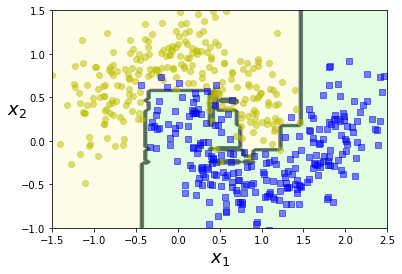

In [2]:
# 데이터 생성 학습,테스트 셋 분리
X, y = make_moons(n_samples=500, noise=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# ada_clf 설정 및 학습시키기
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2), n_estimators=50,
    algorithm="SAMME.R", learning_rate=0.2, random_state=42)
ada_clf.fit(X_train, y_train)

# 정확도 측정
y_pred = ada_clf.predict(X_test)
print("정확도 :",accuracy_score(y_test,y_pred))
plot_decision_boundary(ada_clf, X, y)

정확도 : 0.944


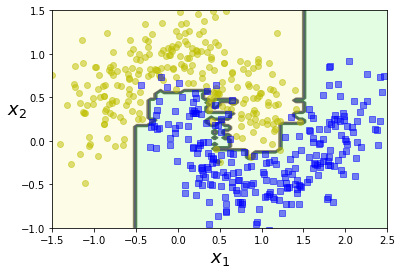

In [3]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred1 = rf_clf.predict(X_test)
print("정확도 :",accuracy_score(y_test,y_pred1))
plot_decision_boundary(rf_clf, X, y)

데이터를 생성하고 그래디언트 부스팅 리그레서로 회귀하기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)
    
X = np.random.rand(100, 1) - 0.5
y = 4*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [ ]:
#에러가 최소가 되는 n_estimators를 찾기
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)
gbrt.fit(X_train, y_train)

#에러가 최소가 되는 bst_n_estimators 찾기
errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)


# 해당 값을 넣어 학습시키기
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=43,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

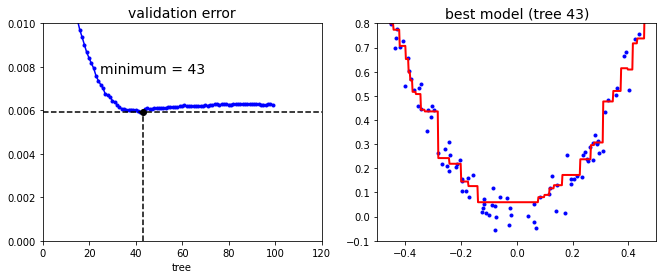

In [ ]:
# 표 그리기 
min_error = np.min(errors)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators*1.1, min_error*1.3, "minimum = %d" %bst_n_estimators, ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("tree")
plt.title("validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("best model (tree %d)" % bst_n_estimators, fontsize=14)

plt.show()

44


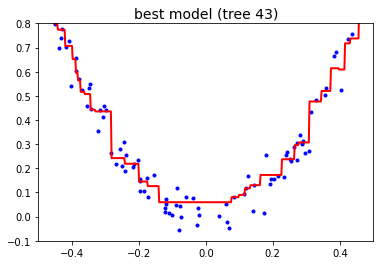

In [ ]:
#n_estimators를 바꿔가며 찾기
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
min_n_estimators = 0
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        min_n_estimators = n_estimators
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

print(min_n_estimators)
min_val_error

plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("best model (tree %d)" % bst_n_estimators, fontsize=14)

plt.show()

load_digits로 데이터 불러오고 앙상블 방법들 정확도 비교하기

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier

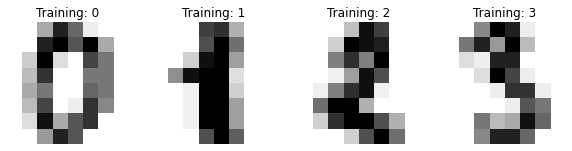

In [ ]:
digits = load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

In [ ]:
# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Split data into 70% train and 30% test subsets
X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.3, shuffle=False)

In [ ]:
decision_tree = DecisionTreeClassifier(random_state = 42)
random_forest = RandomForestClassifier(random_state = 42)

In [ ]:
decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
y_pred_dt = decision_tree.predict(X_test)
y_pred_rf = random_forest.predict(X_test)
print('Decision Tree score:', accuracy_score(y_test, y_pred_dt))
print('Random Forest score:', accuracy_score(y_test, y_pred_rf))

Decision Tree score: 0.7814814814814814
Random Forest score: 0.912962962962963


In [ ]:
from xgboost import XGBClassifier
xgbclf = XGBClassifier()
xgbclf.fit(X_train, y_train)
y_pred_xg = xgbclf.predict(X_test)
print('XGboost:', accuracy_score(y_test, y_pred_xg))

XGboost: 0.8870370370370371
